In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir test_data

In [4]:
import os

In [5]:
one_path = '/content/drive/MyDrive/노출비노출/노출이미지'
two_path = '/content/drive/MyDrive/노출비노출/비노출이미지'

print(len(os.listdir(one_path)))
print(len(os.listdir(two_path)))

500
500


In [ ]:
#for file_path in os.listdir(one_path)[:30]: #노출
 # os.remove(os.path.join(one_path, file_path))
#for files_path in os.listdir(two_path)[:152]: #비노출
 # os.remove(os.path.join(two_path, files_path))


In [ ]:

#print(len(os.listdir(one_path)))
#print(len(os.listdir(two_path)))

500
500


In [6]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import splitfolders

splitfolders.ratio('/content/drive/MyDrive/노출비노출', output='test_data', seed=43, ratio=(.8, .2))

Copying files: 1000 files [00:25, 38.53 files/s]


In [8]:
print(len(os.listdir('/content/test_data/train/노출이미지')))
print(len(os.listdir('/content/test_data/train/비노출이미지')))

print(len(os.listdir('/content/test_data/val/노출이미지')))
print(len(os.listdir('/content/test_data/val/비노출이미지')))

400
400
100
100


In [9]:
import pandas as pd 
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import * 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os 

In [42]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
from tensorflow.keras import optimizers, regularizers

In [224]:
input_tensor = Input(shape=(150,150,3)) #58 나온 원래 코드 150, 150, 3 #224가 디폴트값임.
model = VGG16(weights='imagenet', include_top=False, input_tensor = input_tensor)

In [225]:
# 모델 Layer 데이터화
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Layer 추가
x = layer_dict['block5_pool'].output
# Cov2D Layer +
x = Conv2D(filters = 64, kernel_size=(3, 3), activation='relu')(x)
# MaxPooling2D Layer +
x = MaxPooling2D(pool_size=(2, 2))(x)
# Flatten Layer +
x = Flatten()(x)
# FC Layer +
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid')(x)

# new model 정의
new_model = Model(inputs = model.input, outputs = x)

In [226]:
# CNN Pre-trained 가중치를 그대로 사용할때
for layer in new_model.layers[:19] :
    layer.trainable = False

new_model.summary()

# 컴파일 옵션
new_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer= tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0  

In [227]:
# 테스트 데이터 (고양이/강아지)
train_dir ='/content/test_data/train'
test_dir = '/content/test_data/val'

# 폴더에 따라 자동 분류
train_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# 데이터 구조 생성
train_data_gen = train_image_generator.flow_from_directory(batch_size=16,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(150, 150),
                                                           class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(batch_size=16,
                                                         directory=test_dir,
                                                         target_size=(150, 150),
                                                         class_mode='binary')

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [15]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [16]:
!pip install keras --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [228]:
history = new_model.fit(train_data_gen, epochs=30,
                        validation_data=test_data_gen)

Epoch 1/30
50/50 [==============================] - 13s 232ms/step - loss: 0.7296 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/30
50/50 [==============================] - 13s 267ms/step - loss: 0.6767 - accuracy: 0.5500 - val_loss: 0.7005 - val_accuracy: 0.6050
Epoch 3/30
50/50 [==============================] - 11s 217ms/step - loss: 0.6330 - accuracy: 0.6475 - val_loss: 0.7243 - val_accuracy: 0.5550
Epoch 4/30
50/50 [==============================] - 10s 200ms/step - loss: 0.5772 - accuracy: 0.6988 - val_loss: 0.6880 - val_accuracy: 0.6450
Epoch 5/30
50/50 [==============================] - 11s 220ms/step - loss: 0.4948 - accuracy: 0.7713 - val_loss: 0.7486 - val_accuracy: 0.6500
Epoch 6/30
50/50 [==============================] - 14s 278ms/step - loss: 0.4015 - accuracy: 0.8363 - val_loss: 0.8596 - val_accuracy: 0.6500
Epoch 7/30
50/50 [==============================] - 13s 269ms/step - loss: 0.3706 - accuracy: 0.8462 - val_loss: 0.9555 - val_accuracy: 0.6300

In [64]:
new_model.save("newVGG16(노출비노출).h5") 

In [229]:
# 최종 결과 리포트
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


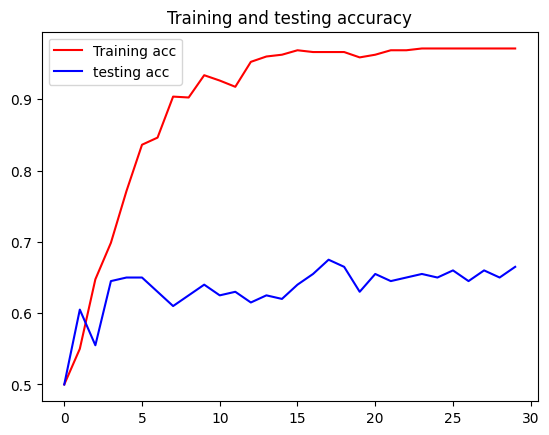

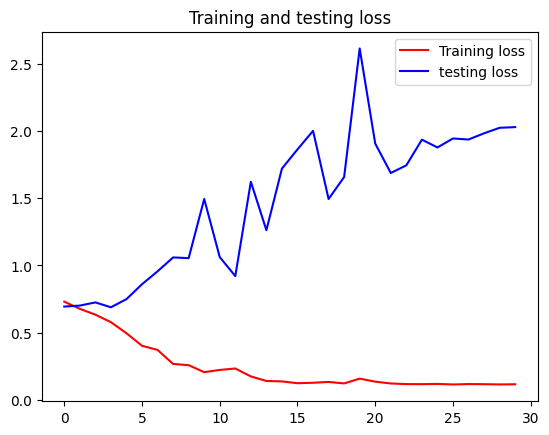

In [230]:
from matplotlib import pyplot as plt

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='testing acc')
plt.title('Training and testing accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='testing loss')
plt.title('Training and testing loss')
plt.legend()

plt.show()